# Klassifikation der in scikit-learn vektorisierten Daten (reduced_labels)

Autorin: Maria Hartmann

In [1]:
# Imports
import os
import time
import pandas as pd
import numpy as np
import scipy.sparse
from matplotlib import pyplot
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Einlesen der vektorisierten Daten

In [2]:
trainset_labels = '../Datasets/reduced_labels_train_idents_labels.csv' 
testset_labels = '../Datasets/reduced_labels_test_idents_labels.csv' 

trainset_csv = pd.read_csv(trainset_labels, delimiter=';')
y_train = trainset_csv['classes'].values
z_train = trainset_csv['url'].values
train_vectors = trainset_csv['filename'].values

testset_csv = pd.read_csv(testset_labels, delimiter=';')
y_test = testset_csv['classes'].values
z_test = testset_csv['url'].values
test_vectors = testset_csv['filename'].values

# Splitten der Labels pro Blogbeitrag
y_train = [e.split(', ') for e in y_train]
y_test = [e.split(', ') for e in y_test]

In [3]:
if len(set(train_vectors)) == 1:
    X_train = scipy.sparse.load_npz('../%s' % train_vectors[0])
else:
    print("Error with len(set(train_vectors))")
if len(set(test_vectors)) == 1:
    X_test = scipy.sparse.load_npz('../%s' % test_vectors[0])
else:
    print("Error with len(set(test_vectors))")

In [4]:
print(z_train[0])
print(y_train[0])
print(test_vectors[0])
print(X_train.shape)
X_train

archivalia.hypotheses.org/575
['pluridisciplinarité_d', 'épistémologie et méthodes_t', 'histoire_t', 'histoire et archéologie_d']
Datasets/reduced_labels_test_scikit-learn_sparse_matrix.npz
(17109, 10000)


<17109x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2386946 stored elements in Compressed Sparse Row format>

In [5]:
dim = X_train.shape[1]
print(dim)

10000


In [6]:
output_dir = "../reduced_labels" 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

k-hot-Kodierung der Labels

In [7]:
# k-hot-encode labels mit MultiLabelBinarizer
label_encoder = MultiLabelBinarizer()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)
print(encoded_y_train[0])

[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [8]:
print(len(label_encoder.classes_))
for i, element in enumerate(label_encoder.classes_):
    print(i, element)

35
0 administration publique et développement_d
1 anthropologie_t
2 arts et humanités_d
3 asie_t
4 bibliothéconomie_d
5 droit_t
6 ethnologie_t
7 europe_t
8 géographie_t
9 histoire et archéologie_d
10 histoire_t
11 information_t
12 langage_t
13 langue et linguistique_d
14 littérature_d
15 moyen âge_t
16 pensée_t
17 pluridisciplinarité_d
18 psychisme_t
19 psychologie_d
20 religions_t
21 représentations_t
22 sciences de l'information et de la communication_d
23 sciences de la santé et de la santé publique_d
24 sciences politiques_d
25 sociologie et anthropologie_d
26 sociologie_t
27 travail social et politique sociale_d
28 éducation_d
29 éducation_t
30 épistémologie et méthodes_t
31 époque contemporaine_t
32 époque moderne_t
33 études des sciences_t
34 études du politique_t


# Klassifikation mit MLPClassifier

In [9]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(4096,1024), validation_fraction=0.1, early_stopping=True, verbose=True, random_state=1)
mlp_start = time.time()
mlp_clf = mlp_clf.fit(X_train, encoded_y_train)
mlp_time = (time.time() - mlp_start)/60

Iteration 1, loss = 7.71963544
Validation score: 0.417884
Iteration 2, loss = 3.51733982
Validation score: 0.542373
Iteration 3, loss = 1.53049433
Validation score: 0.548802
Iteration 4, loss = 0.61838623
Validation score: 0.556400
Iteration 5, loss = 0.31824075
Validation score: 0.552893
Iteration 6, loss = 0.23207093
Validation score: 0.537697
Iteration 7, loss = 0.21266148
Validation score: 0.534775
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


In [10]:
print(mlp_time)
mlp_predicted = mlp_clf.predict(X_test)

23.768892780939737


In [11]:
mlp_precision = precision_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_precision)
mlp_recall = recall_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_recall)
mlp_f1 = f1_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_f1)

0.8596379037823638
0.8138036428534324
0.8247182393457454


c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [ ]:
loss_values = mlp_clf.loss_curve_
print(loss_values)
pyplot.title('Loss on training data (reduced_labels)')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.plot(loss_values)
pyplot.savefig('%s/all_labels_mlp_plot_loss.png' % output_dir)
pyplot.show()

In [ ]:
validation_scores = mlp_clf.validation_scores_
print(validation_scores)
pyplot.title('Accuracy on validation data (reduced_labels)')
pyplot.xlabel('epochs')
pyplot.ylabel('acc')
pyplot.plot(validation_scores)
pyplot.savefig('%s/all_labels_mlp_plot_val_acc.png' % output_dir)
pyplot.show()

# Klassifikation mit Dense-Layer in Keras

In [24]:
# Keras model 

dense_model = Sequential()
dense_model.add(Dense(4096, input_dim=dim, activation="relu"))
dense_model.add(Dropout(0.4))
dense_model.add(Dropout(0.4))
dense_model.add(Dropout(0.4))
dense_model.add(Dense(1024, activation="relu"))
dense_model.add(Dropout(0.4))
dense_model.add(Dropout(0.4))
dense_model.add(Dropout(0.4))
dense_model.add(Dense(len(label_encoder.classes_), activation="sigmoid"))

summary = dense_model.summary()
print("\n", summary)
config = dense_model.get_config()
print("\n", config)

# compile keras model
lossfunction = 'binary_crossentropy'
optimizer = "adam"
metrics = ['accuracy']

dense_model.compile(loss=lossfunction, 
              optimizer=optimizer,
              metrics=metrics)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=7, verbose=10),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=10),
                 ]

# train keras model
batch_size = 32
epochs = 100
dense_start = time.time()
dense_estimator = dense_model.fit(X_train,
                            np.array(encoded_y_train), 
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=10, 
                            validation_split=0.1,
                            shuffle=True
                           )

dense_time = (time.time() - dense_start)/60
print("Laufzeit in Minuten:", dense_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4096)              40964096  
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
__________

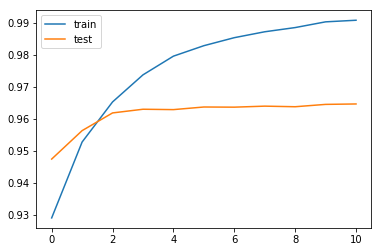

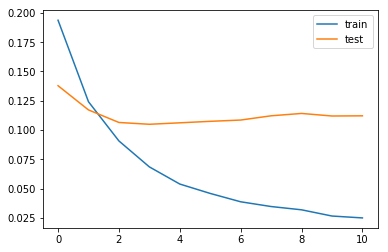

In [25]:
# visualize the train and validate loss and accuracy

# plot history for accuracy
pyplot.plot(dense_estimator.history['acc'], label='train')
pyplot.plot(dense_estimator.history['val_acc'], label='test')
pyplot.legend()
pyplot.savefig('%s/reduced_labels_dense_plot_acc.png' % output_dir)
pyplot.show()
pyplot.close()

# plot history for loss
pyplot.plot(dense_estimator.history['loss'], label='train')
pyplot.plot(dense_estimator.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('%s/reduced_labels_dense_plot_loss.png' % output_dir)
pyplot.show()
pyplot.close()

In [26]:
print(dense_time)
dense_predicted = dense_model.predict_proba(X_test)

59.40335252682368


In [27]:
print(dense_predicted[0].round())
print(encoded_y_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [28]:
dense_precision = precision_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_precision)
dense_recall = recall_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_recall)
dense_f1 = f1_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_f1)

0.8637551043055952
0.8624904457653405
0.8561092500582034


Ohne Dropout:

Precision: 0.8664668625748569
Recall: 0.8243970628612984
F1-Score: 0.8343708633948713

Mit einer Dropout-Schicht (0,4):

Precision: 0.868548016058535
Recall: 0.8362136104246903
F1-Score: 0.8428356320640372

Mit drei Dropout-Schichten (0,4):

Precision: 0.8637551043055952
Recall: 0.8624904457653405
F1-Score: 0.8561092500582034

# Klassifikation mit LSTM-Layer in Keras

In [37]:
# LSTM in Keras
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=dim, output_dim=128))
lstm_model.add(LSTM(64, activation="relu"))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(len(label_encoder.classes_), activation="sigmoid"))

summary = lstm_model.summary()
print("\n", summary)
config = lstm_model.get_config()
print("\n", config)

# compile keras model
lossfunction = 'binary_crossentropy'
optimizer = "adam"
metrics = ['accuracy']

lstm_model.compile(loss=lossfunction,
                   optimizer=optimizer,
                   metrics=metrics)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=4, verbose=10),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=10),
                 ]

# train keras model
batch_size = 32
epochs = 100
lstm_start = time.time()
lstm_estimator = lstm_model.fit(X_train,
                            np.array(encoded_y_train), 
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=10, 
                            validation_split=0.1,
                            shuffle=True
                           )

lstm_time = (time.time() - lstm_start)/60
print("Laufzeit in Minuten:", lstm_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 35)                2275      
Total params: 1,331,683
Trainable params: 1,331,683
Non-trainable params: 0
_________________________________________________________________

 None

 [{'class_name': 'Embedding', 'config': {'name': 'embedding_2', 'trainable': True, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 10000, 'output_dim': 128, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': 

c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:529: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:953: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


Epoch 2/100


KeyboardInterrupt: 

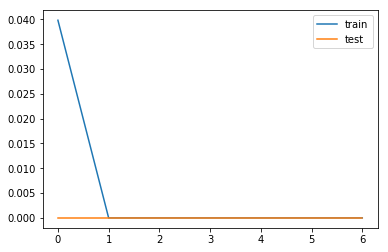

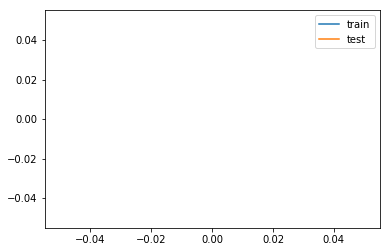

In [30]:
# visualize the train and validate loss and accuracy

# plot history for accuracy
pyplot.plot(lstm_estimator.history['acc'], label='train')
pyplot.plot(lstm_estimator.history['val_acc'], label='test')
pyplot.legend()
pyplot.savefig('%s/reduced_labels_lstm_plot_acc.png' % output_dir)
pyplot.show()
pyplot.close()

# plot history for loss
pyplot.plot(lstm_estimator.history['loss'], label='train')
pyplot.plot(lstm_estimator.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('%s/reduced_labels_lstm_plot_loss.png' % output_dir)
pyplot.show()
pyplot.close()

In [33]:
print(lstm_time)
lstm_predicted = lstm_model.predict_proba(X_test)

c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\models.py:1152: RuntimeWarning: invalid value encountered in less
  if preds.min() < 0. or preds.max() > 1.:
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\models.py:1152: RuntimeWarning: invalid value encountered in greater
  if preds.min() < 0. or preds.max() > 1.:


In [36]:
print(lstm_predicted[0])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [35]:
lstm_precision = precision_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_precision)
lstm_recall = recall_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_recall)
lstm_f1 = f1_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_f1)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets